# COVID-19 pandemic data analysis

### Obtain data from John Hopkins CSSE repository 

Using @GaelVaroquaux [`covid-dashboard`](https://github.com/covid19-dash/covid-dashboard) helpers

In [1]:
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, "./covid-dashboard/")

In [2]:
import data_input

data = data_input.get_data()

In [11]:
data

type             confirmed                                              \
iso                    AFG    AGO     ALB     AND                  ARE   
country_region Afghanistan Angola Albania Andorra United Arab Emirates   
date                                                                     
2020-01-22               0      0       0       0                    0   
2020-01-23               0      0       0       0                    0   
2020-01-24               0      0       0       0                    0   
2020-01-25               0      0       0       0                    0   
2020-01-26               0      0       0       0                    0   
...                    ...    ...     ...     ...                  ...   
2020-04-02             273      8     277     428                 1024   
2020-04-03             281      8     304     439                 1264   
2020-04-04             299     10     333     466                 1505   
2020-04-05             349     14     361     501                 1799   
2020-04-06             367     16     377     525                 2076   

type                                                                    ...  \
iso                  ARG     ARM                 ATG       AUS     AUT  ...   
country_region Argentina Armenia Antigua and Barbuda Australia Austria  ...   
date                                                                    ...   
2020-01-22             0       0                   0         0       0  ...   
2020-01-23             0       0                   0         0       0  ...   
2020-01-24             0       0                   0         0       0  ...   
2020-01-25             0       0                   0         0       0  ...   
2020-01-26             0       0                   0         4       0  ...   
...                  ...     ...                 ...       ...     ...  ...   
2020-04-02          1133     663                   9      5116   11129  ...   
2020-04-03          1265     736                  15      5330   11524  ...   
2020-04-04          1451     770                  15      5550   11781  ...   
2020-04-05          1451     822                  15      5687   12051  ...   
2020-04-06          1554     833                  15      5797   12297  ...   

type             death                                   \
iso                UKR     URY           USA        UZB   
country_region Ukraine Uruguay United States Uzbekistan   
date                                                      
2020-01-22           0       0             0          0   
2020-01-23           0       0             0          0   
2020-01-24           0       0             0          0   
2020-01-25           0       0             0          0   
2020-01-26           0       0             0          0   
...                ...     ...           ...        ...   
2020-04-02          22       4          5926          2   
2020-04-03          27       4          7087          2   
2020-04-04          32       5          8407          2   
2020-04-05          37       5          9619          2   
2020-04-06          38       6         10783          2   

type                                                               \
iso                                         VCT       VEN     VNM   
country_region Saint Vincent and the Grenadines Venezuela Vietnam   
date                                                                
2020-01-22                                    0         0       0   
2020-01-23                                    0         0       0   
2020-01-24                                    0         0       0   
2020-01-25                                    0         0       0   
2020-01-26                                    0         0       0   
...                                         ...       ...     ...   
2020-04-02                                    0         5       0   
2020-04-03                                    0         7 

### Select countries of interest and retrieve confirmed cases and deaths dataframes

In [12]:
COUNTRIES = ["ESP", "GBR", "DEU", "AUT"]

In [13]:
confirmed = data["confirmed"][COUNTRIES]
dead = data["death"][COUNTRIES]

Text(0.5, 1.0, 'Log-scale plot of number of confirmed cases')

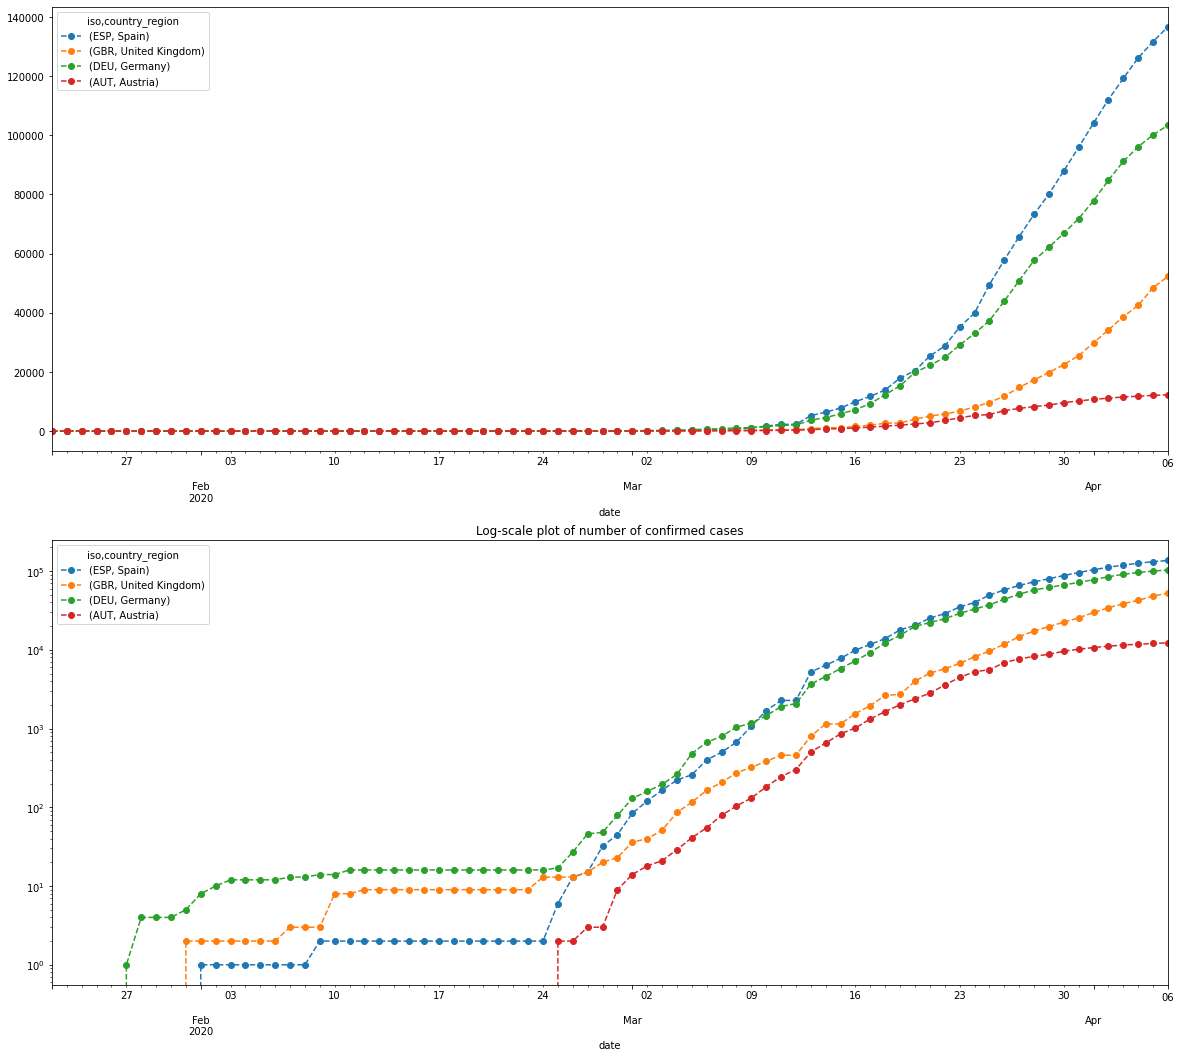

In [14]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20,18))
confirmed.plot(ax=top_ax, linestyle="--", marker="o")
confirmed.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale('log')
bottom_ax.set_title("Log-scale plot of number of confirmed cases")

Text(0.5, 1.0, 'Log-scale plot of number of total deaths (daily confirmed)')

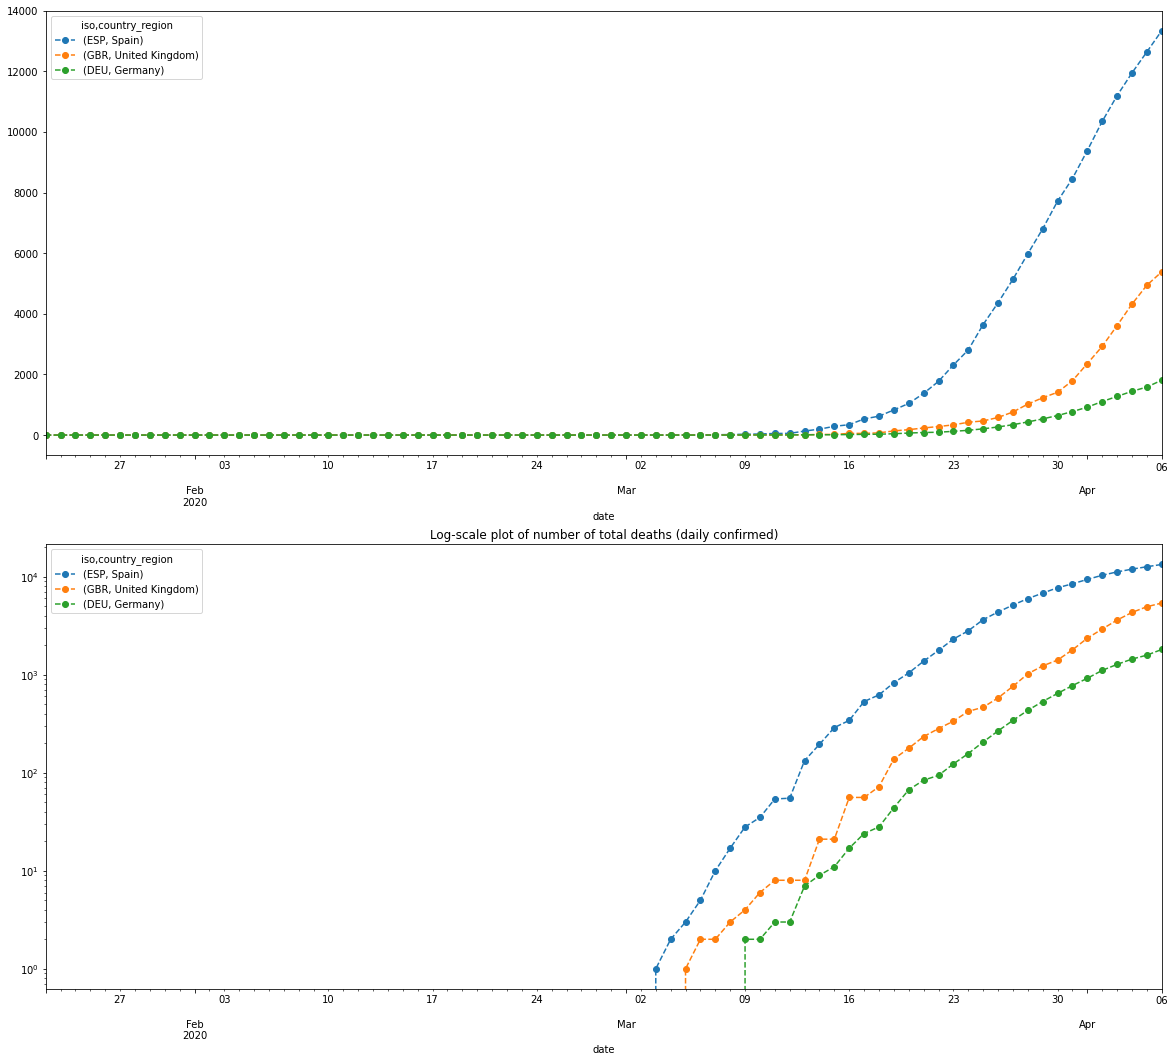

In [8]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20,18))
dead.plot(ax=top_ax, linestyle="--", marker="o")
dead.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale('log')
bottom_ax.set_title("Log-scale plot of number of total deaths (daily confirmed)")

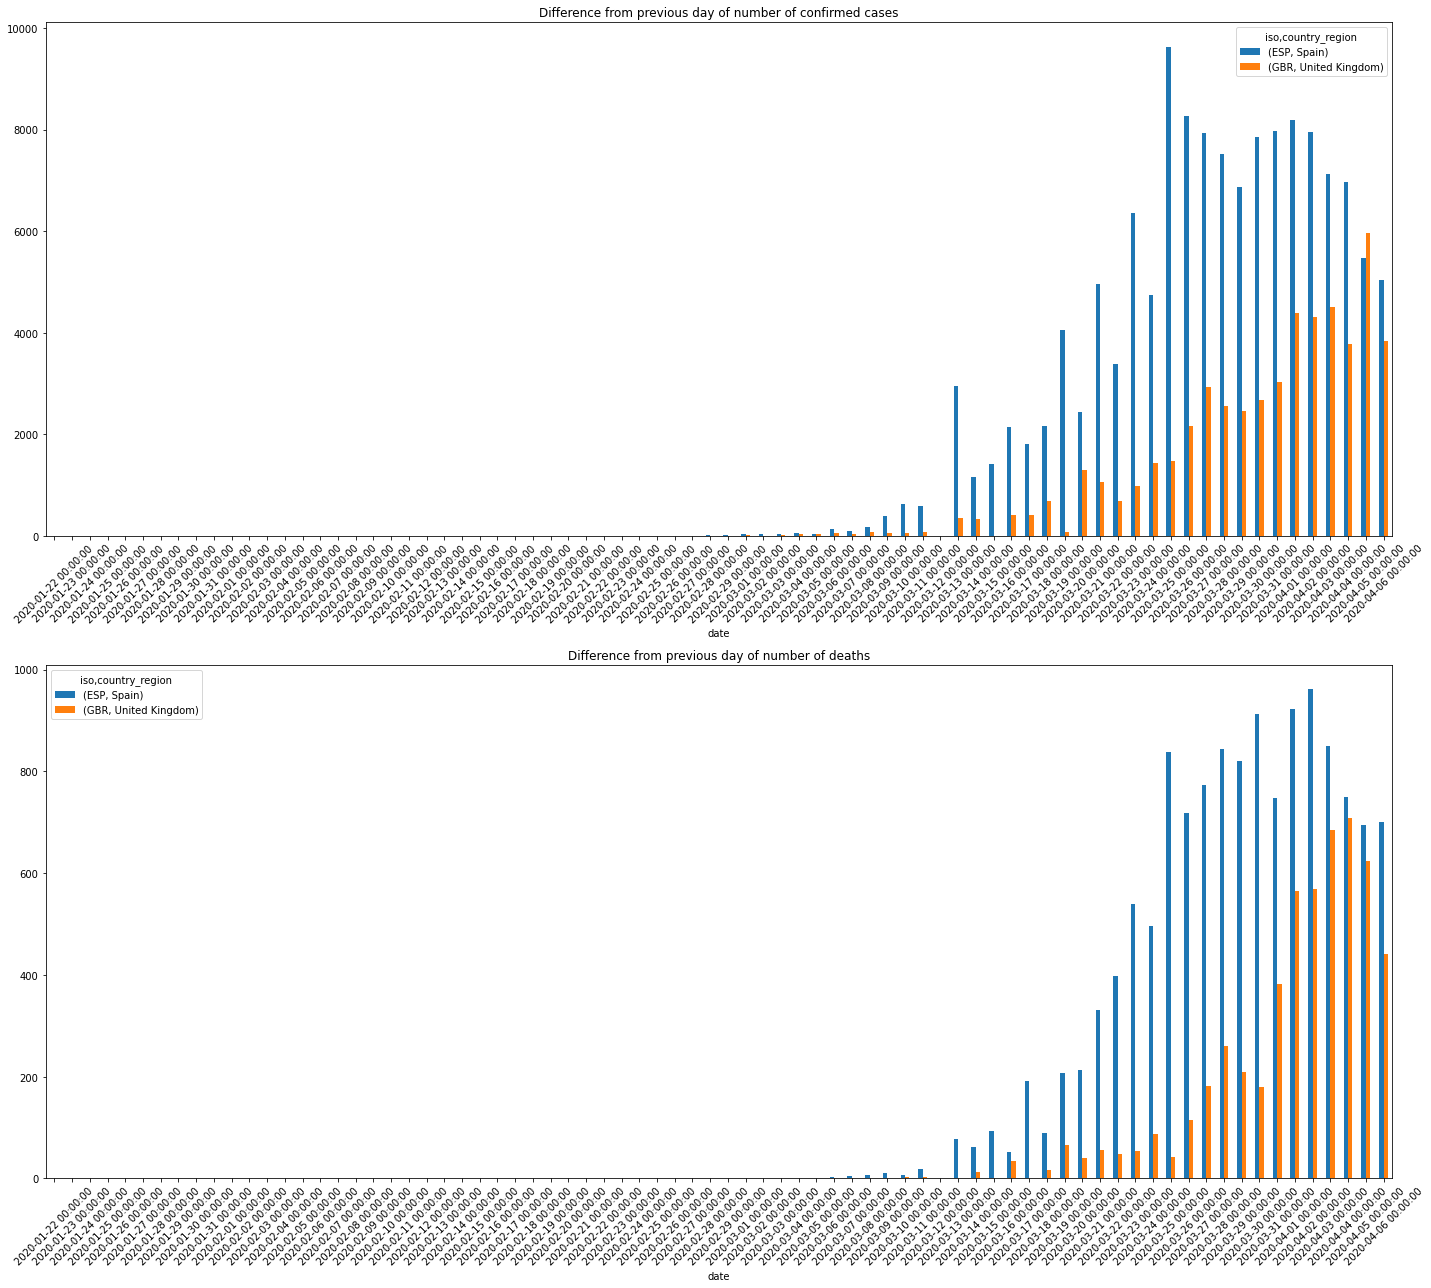

In [17]:
confirmed = confirmed[["ESP", "GBR"]]
dead = dead[["ESP", "GBR"]]
growth_rate = confirmed.pct_change()
abs_growth_confirmed = confirmed.diff()
abs_growth_deaths = dead.diff()
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20,18))
abs_growth_confirmed.plot.bar(ax=top_ax, rot=45)
abs_growth_deaths.plot.bar(ax=bottom_ax, rot=45)
# plt.setp(top_ax.get_xticklabels()[::2], visible=False)
# plt.setp(bottom_ax.get_xticklabels()[::2], visible=False)
top_ax.set_title("Difference from previous day of number of confirmed cases")
bottom_ax.set_title("Difference from previous day of number of deaths")
plt.tight_layout()

## Predictive model: a simple approach

In [23]:
import numpy as np

NUM_DAYS = 10  # How many days ago, length of the window
# Build exponential weighting function

def exp_window(length=NUM_DAYS, growth=1.1):
    window = growth ** np.arange(length)
    window = window/window.sum()
    return window

Text(0.5, 1.0, 'Weights over 14 days.')

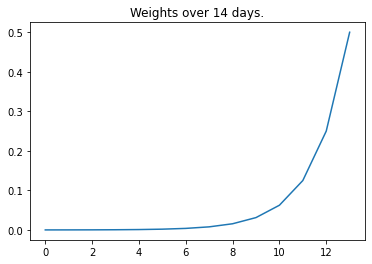

In [24]:
weighted_window = exp_window(length=14, growth=2)
plt.figure()
plt.plot(weighted_window)
plt.title("Weights over 14 days.")